# Análise exploratória dos dados

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('fivethirtyeight') # estilo dos gráficos

import warnings # retirar avisos
warnings.filterwarnings('ignore')

In [2]:
df_load = pd.read_csv("daily_load.csv", parse_dates = ["date"])

In [3]:
df_load.head() # load_mwmed: carga própria de energia

,id_reg,desc_reg,date,load_mwmed
0,N,NORTE,2000-01-01,2243.512500
1,NE,NORDESTE,2000-01-01,4646.370833
2,S,SUL,2000-01-01,4800.650000
3,SE,SUDESTE,2000-01-01,19045.995833
4,N,NORTE,2000-01-02,2259.808333


In [10]:
df_load_sul = df_load[df_load["id_reg"] == "S"].reset_index(drop = True) # filtro para a região sul

In [12]:
dt_min = df_load_sul.date.min()
dt_max = df_load_sul.date.max()

print(f"Data mínima: {dt_min}")
print(f"Data máxia: {dt_max}")

Data mínima: 2000-01-01 00:00:00
Data máxia: 2022-05-11 00:00:00


In [11]:
df_load_sul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8168 entries, 0 to 8167
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id_reg      8168 non-null   object        
 1   desc_reg    8168 non-null   object        
 2   date        8168 non-null   datetime64[ns]
 3   load_mwmed  8155 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 255.4+ KB


In [13]:
df_load_sul.isna().sum() 

id_reg         0
desc_reg       0
date           0
load_mwmed    13
dtype: int64

In [14]:
# PREENCHENDO VALORES VAZIOS
df_load_sul.sort_values(by = "date", inplace = True)
df_load_sul.interpolate(inplace = True) 

In [15]:
# CRIANDO VARIÁVEIS DE CALENDÁRIO
df_load_sul["ano"] = df_load_sul.date.dt.year
df_load_sul["trimestre"] = df_load_sul.date.dt.quarter
df_load_sul["mes"] = df_load_sul.date.dt.month
df_load_sul["dia"] = df_load_sul.date.dt.day
df_load_sul["dia_ano"] = df_load_sul.date.dt.dayofyear
df_load_sul["dia_semana"] = df_load_sul.date.dt.weekday + 1    # 1: segunda-feira; 7: domingo
df_load_sul["semana_ano"] = df_load_sul.date.dt.isocalendar().week
df_load_sul["apagao"] = df_load_sul.date.dt.year.apply(lambda x: 1 if x in [2001, 2002] else 0) # apagão de 2001 e 2002

In [16]:
df_load_sul.head()

,id_reg,desc_reg,date,load_mwmed,ano,trimestre,mes,dia,dia_ano,dia_semana,semana_ano,apagao
0,S,SUL,2000-01-01,4800.650000,2000,1,1,1,1,6,52,0
1,S,SUL,2000-01-02,4899.800000,2000,1,1,2,2,7,52,0
2,S,SUL,2000-01-03,6261.554167,2000,1,1,3,3,1,1,0
3,S,SUL,2000-01-04,6733.741667,2000,1,1,4,4,2,1,0
4,S,SUL,2000-01-05,6961.170833,2000,1,1,5,5,3,1,0


In [17]:
df_load_sul.describe()

,load_mwmed,ano,trimestre,mes,dia,dia_ano,dia_semana,semana_ano,apagao
count,8168.000000,8168.000000,8168.000000,8168.000000,8168.000000,8168.000000,8168.000000,8168.000000,8168.000000
mean,9216.057338,2010.684378,2.489104,6.460945,15.712659,181.239594,4.000122,26.329456,0.089373
std,2128.382916,6.457349,1.119910,3.458540,8.802352,105.747510,2.000337,15.111376,0.285299
min,4465.691251,2000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,7514.780936,2005.000000,1.000000,3.000000,8.000000,89.000000,2.000000,13.000000,0.000000
50%,8985.885745,2011.000000,2.000000,6.000000,16.000000,180.000000,4.000000,26.000000,0.000000
75%,10871.065084,2016.000000,3.000000,9.000000,23.000000,273.000000,6.000000,39.000000,0.000000
max,16219.351042,2022.000000,4.000000,12.000000,31.000000,366.000000,7.000000,53.000000,1.000000


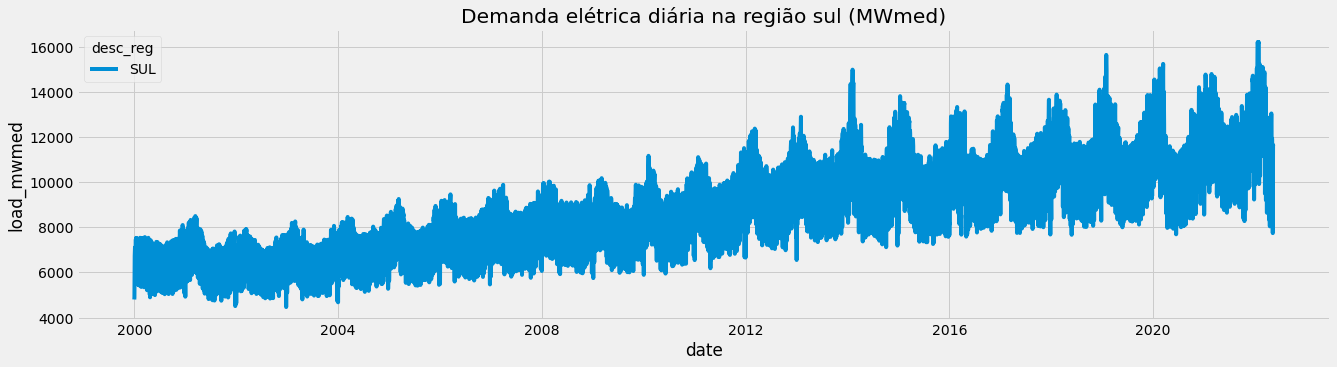

In [18]:
plt.figure(figsize = (20, 5))

sns.lineplot(x = "date", y = "load_mwmed", hue = "desc_reg", data = df_load_sul)

plt.title("Demanda elétrica diária na região sul (MWmed)")

plt.show()

In [13]:
fig = px.scatter(df_load_sul, x = "date", y = "load_mwmed", 
                labels=dict(date="Data", load_mwmed="Carga de energia (MWmed)"),
                template = 'plotly_dark'
                )

fig.show()

In [19]:
df_load_sul_2021 = df_load_sul[df_load_sul["ano"] == 2021]

fig = px.line(df_load_sul_2021, x = "date", y = "load_mwmed", title = "Demanda elétrica diária na região sul - 2021 (MWmed)")

fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)'
})

fig.show()

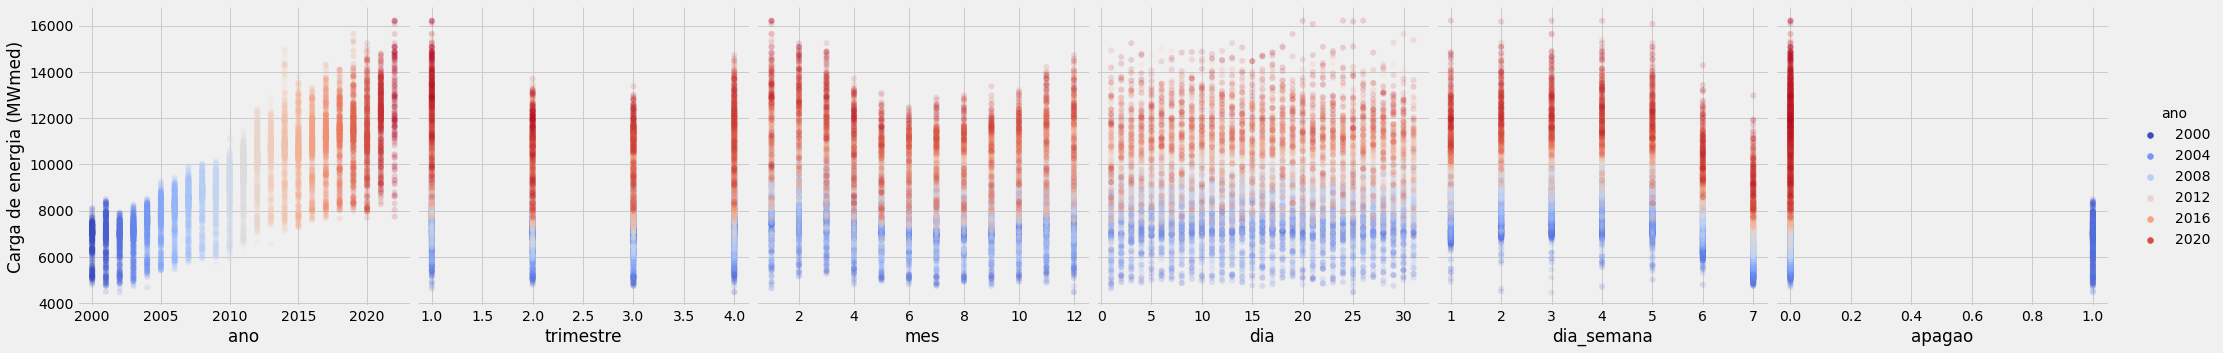

In [20]:
g = sns.pairplot(df_load_sul, 
             hue = "ano", 
             x_vars = [ "ano", "trimestre", "mes", "dia", "dia_semana", "apagao"],
             y_vars = "load_mwmed",
             height = 5,
             plot_kws={'alpha':0.15, 'linewidth':0, 'palette': 'coolwarm'})

g.axes.flat[0].set_ylabel("Carga de energia (MWmed)")

plt.show()

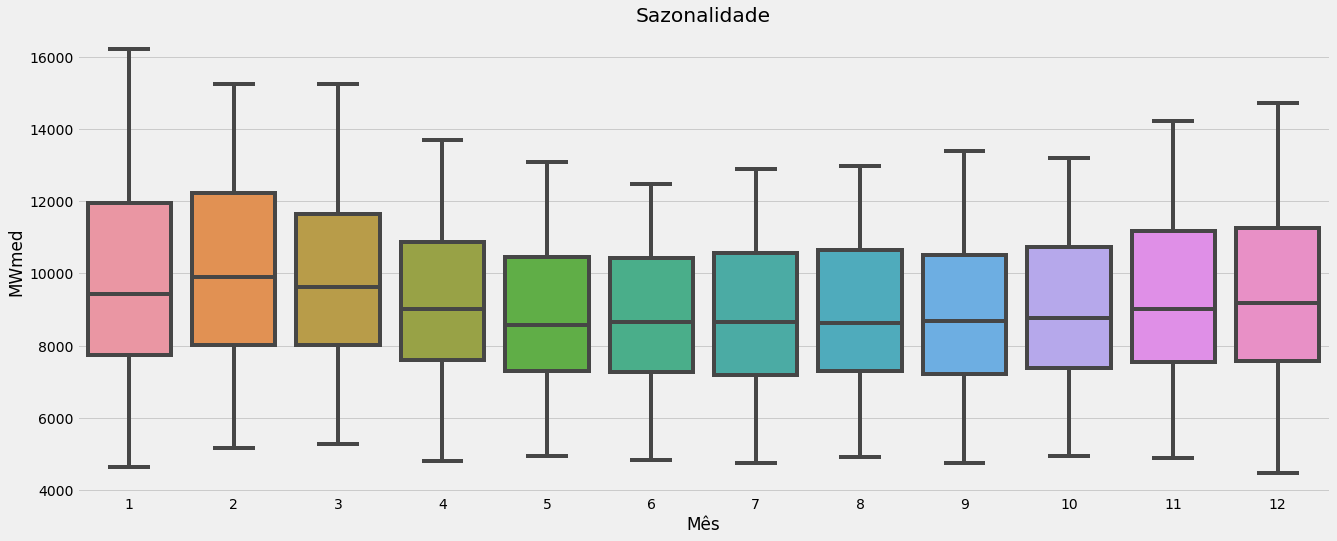

In [21]:
    plt.figure(figsize = (20, 8))

    sns.boxplot(df_load_sul["mes"], df_load_sul["load_mwmed"])
    
    plt.title("Sazonalidade")
    plt.ylabel("MWmed")
    plt.xlabel("Mês")
    
    plt.show()

In [22]:
# MÉDIAS MÓVEIS
wdws = [7, 30, 365]
rolling_window_columns = []
for wdw in wdws:
    col = "rolling_" + str(wdw)
    rolling_window_columns.append(col)
    df_load_sul[col] = df_load_sul["load_mwmed"].rolling(wdw).mean()

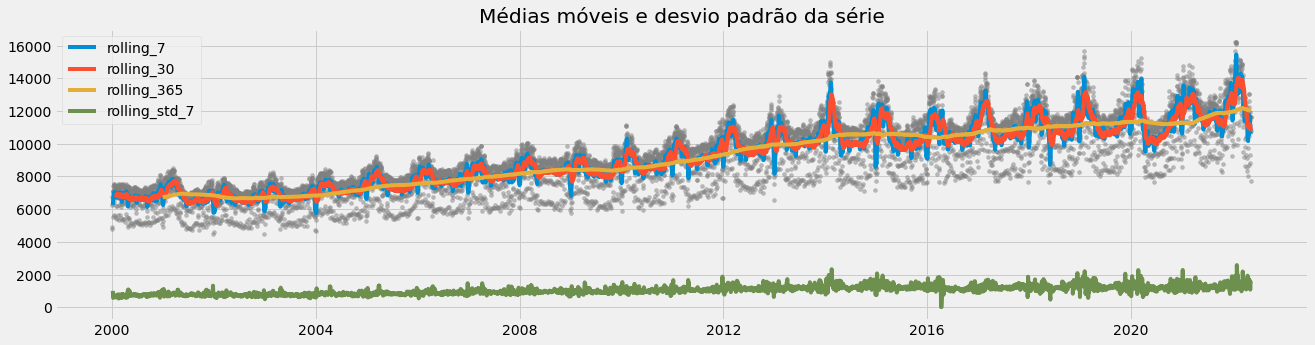

In [126]:
plt.figure(figsize = (20, 5))

plt.scatter(df_load_sul["date"], df_load_sul["load_mwmed"], alpha=.5, c = "gray", s = 15)
for rw in rolling_window_columns:
    plt.plot(df_load_sul["date"], df_load_sul[rw], label = rw)

plt.plot(df_load_sul["date"], df_load_sul["load_mwmed"].rolling(7).std(), label = "rolling_std_7")

plt.title(f"Médias móveis e desvio padrão da série")
plt.legend()

plt.show()

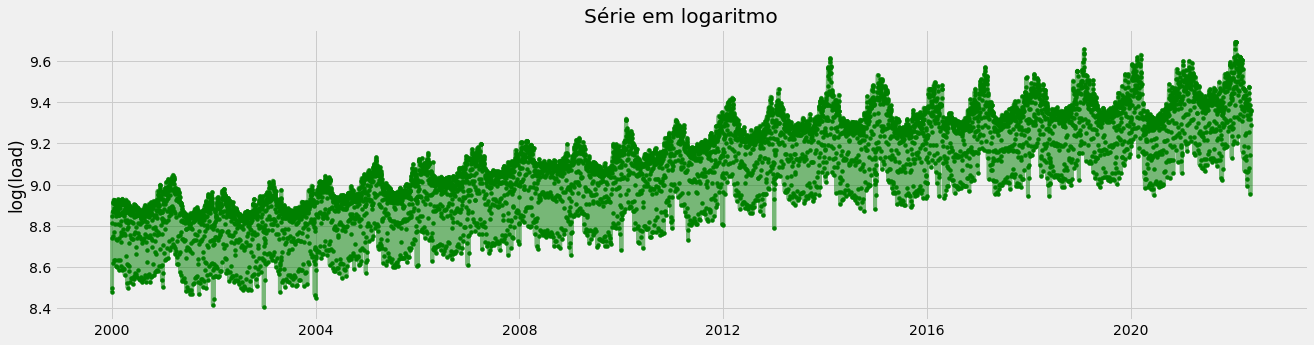

In [24]:
plt.figure(figsize = (20, 5))

plt.scatter(df_load_sul["date"], np.log(df_load_sul["load_mwmed"]), c = "green", s = 15)
plt.plot(df_load_sul["date"], np.log(df_load_sul["load_mwmed"]), alpha = .5, c = "green")

plt.title(f"Série em logaritmo")
plt.ylabel("log(load)")

plt.show()

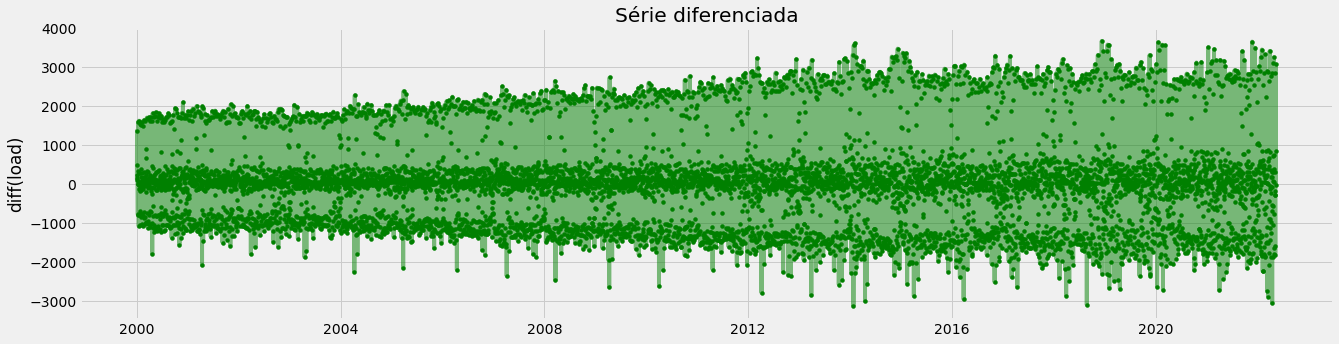

In [25]:
plt.figure(figsize = (20, 5))

plt.scatter(df_load_sul["date"], df_load_sul["load_mwmed"].diff(), c = "green", s = 15)
plt.plot(df_load_sul["date"], df_load_sul["load_mwmed"].diff(), alpha=.5, c = "green")

plt.title(f"Série diferenciada")
plt.ylabel("diff(load)")

plt.show()

## Autocorrelação

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

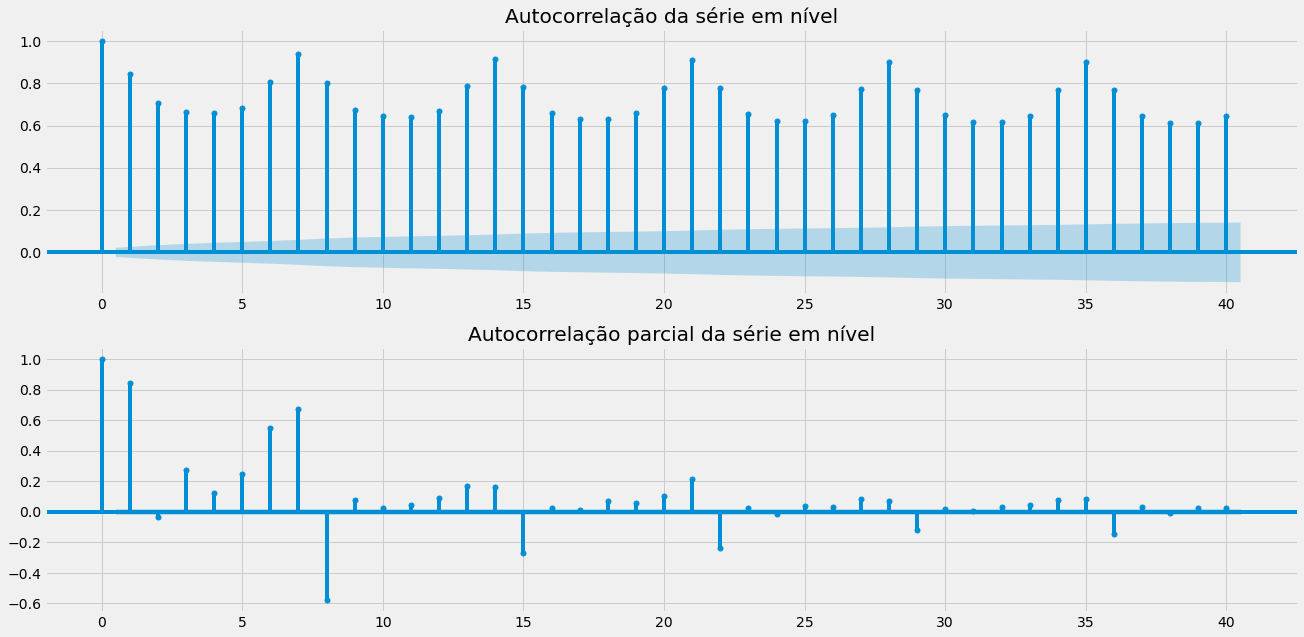

In [89]:
N, M = 20, 10
fig, (ax1, ax2) = plt.subplots(2, figsize = (N,M))
plot_acf(df_load_sul["load_mwmed"], title = "Autocorrelação da série em nível", ax = ax1)
plot_pacf(df_load_sul["load_mwmed"], title = "Autocorrelação parcial da série em nível", ax = ax2)
plt.show()

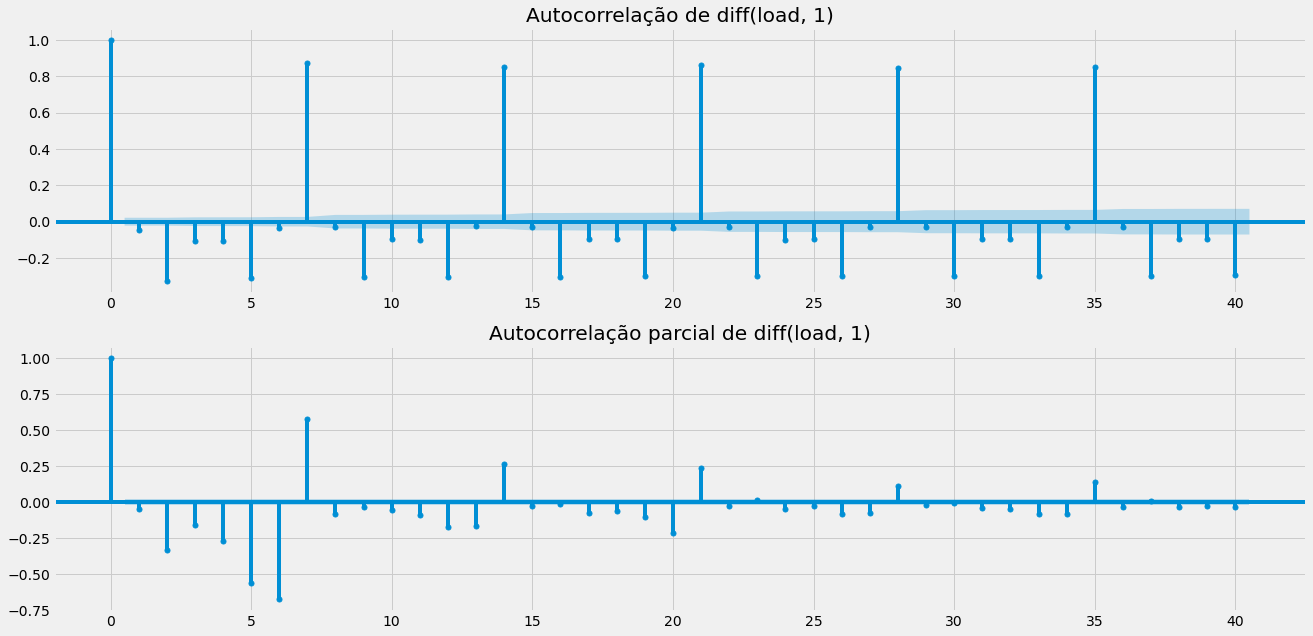

In [90]:
df_load_sul_diff1 = df_load_sul["load_mwmed"].diff().dropna()

N, M = 20, 10
fig, (ax1, ax2) = plt.subplots(2, figsize = (N,M))
plot_acf(df_load_sul_diff1, title = "Autocorrelação de diff(load, 1)", ax = ax1)
plot_pacf(df_load_sul_diff1, title = "Autocorrelação parcial de diff(load, 1)", ax = ax2)
plt.show()

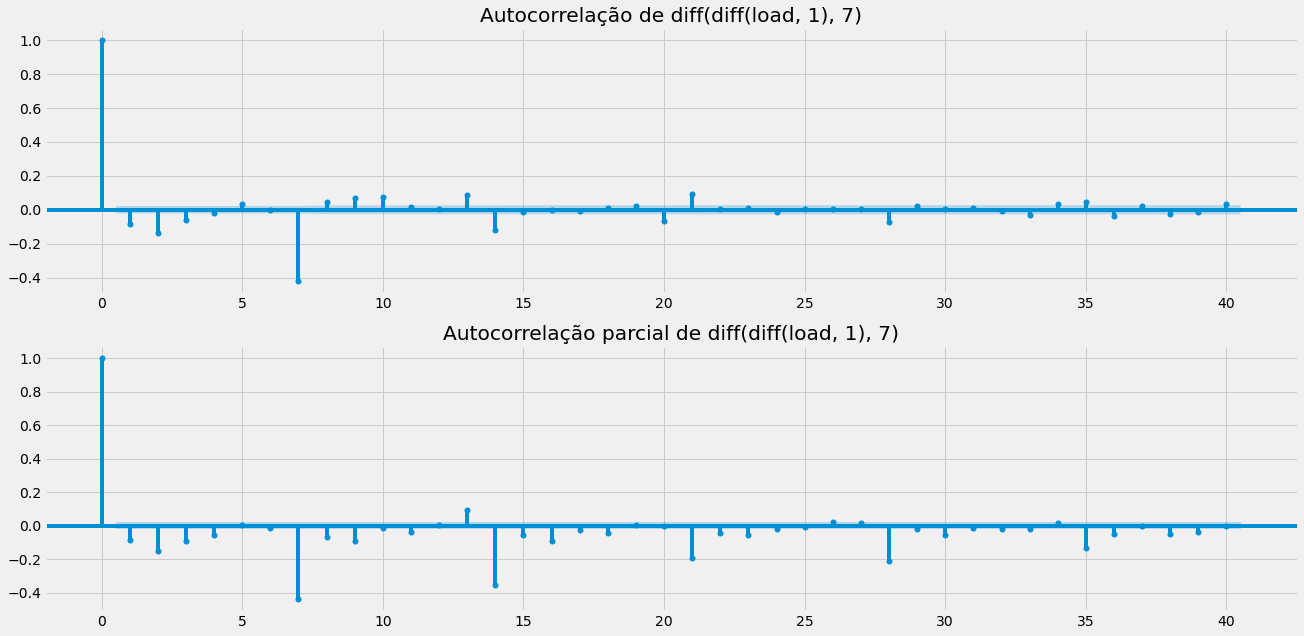

In [92]:
df_load_sul_diff1_diff7 = df_load_sul_diff1.diff(7).dropna()

N, M = 20, 10
fig, (ax1, ax2) = plt.subplots(2, figsize = (N,M))
plot_acf(df_load_sul_diff1_diff7, title = "Autocorrelação de diff(diff(load, 1), 7)", ax = ax1)
plot_pacf(df_load_sul_diff1_diff7, title = "Autocorrelação parcial de diff(diff(load, 1), 7)", ax = ax2)
plt.show()

## Estacionariedade

In [98]:
from statsmodels.tsa.stattools import adfuller, kpss

In [109]:
result = adfuller(df_load_sul["load_mwmed"])
print('P-valor da série em nível: %f' % result[1])
print('Estatística ADF: %f' % result[0])
print('Valores críticos:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

P-valor da série em nível: 0.109747
Estatística ADF: -2.523987
Valores críticos:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [112]:
result = adfuller(np.log(df_load_sul["load_mwmed"]))
print('P-valor da série em logaritmo: %f' % result[1])
print('Estatística ADF: %f' % result[0])
print('Valores críticos:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

P-valor da série em logaritmo: 0.159958
Estatística ADF: -2.338151
Valores críticos:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [119]:
result = adfuller(df_load_sul_diff1)
print('P-valor da série diferenciada: %f' % result[1])
print('Estatística ADF: %f' % result[0])
print('Valores críticos:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

P-valor da série diferenciada: 0.000000
Estatística ADF: -20.539333
Valores críticos:
	1%: -3.431
	5%: -2.862
	10%: -2.567


## Distribuição

In [137]:
from scipy.stats import boxcox

In [140]:
# Transformações
x_norm = (df_load_sul["load_mwmed"] - df_load_sul["load_mwmed"].mean())/df_load_sul["load_mwmed"].std()
x_log = np.log(df_load_sul["load_mwmed"])
x_boxcox = boxcox(df_load_sul["load_mwmed"])[0]
x_diff = df_load_sul["load_mwmed"].diff()

series = {
        "Nível": df_load_sul["load_mwmed"],
        "(x - x̅)/σ": x_norm,
        "Logaritmo": x_log,
        "Boxcox": x_boxcox,
        "Série diferenciada": x_diff
        }

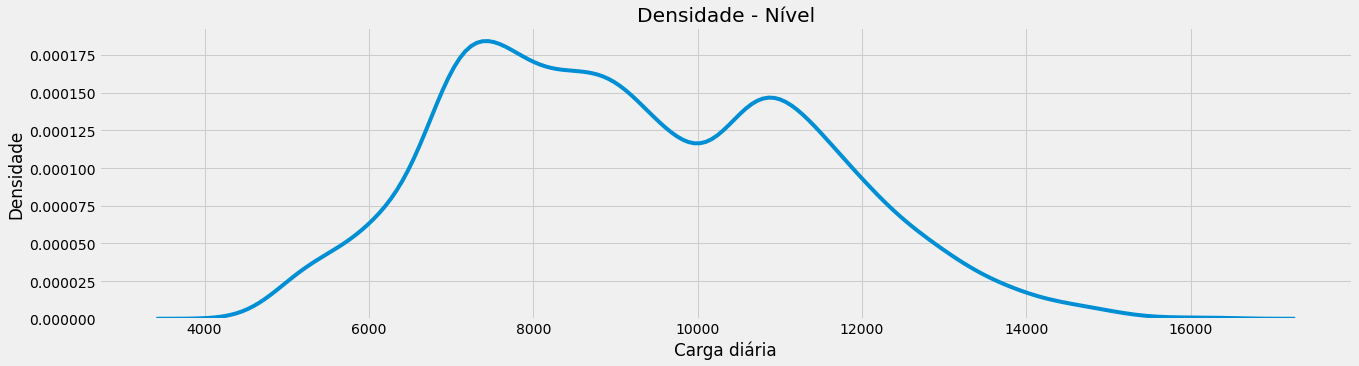

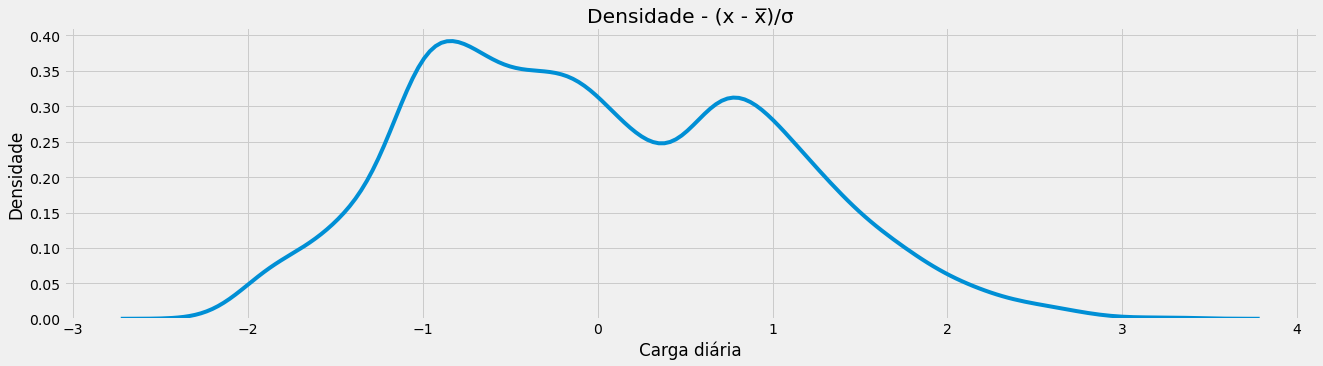

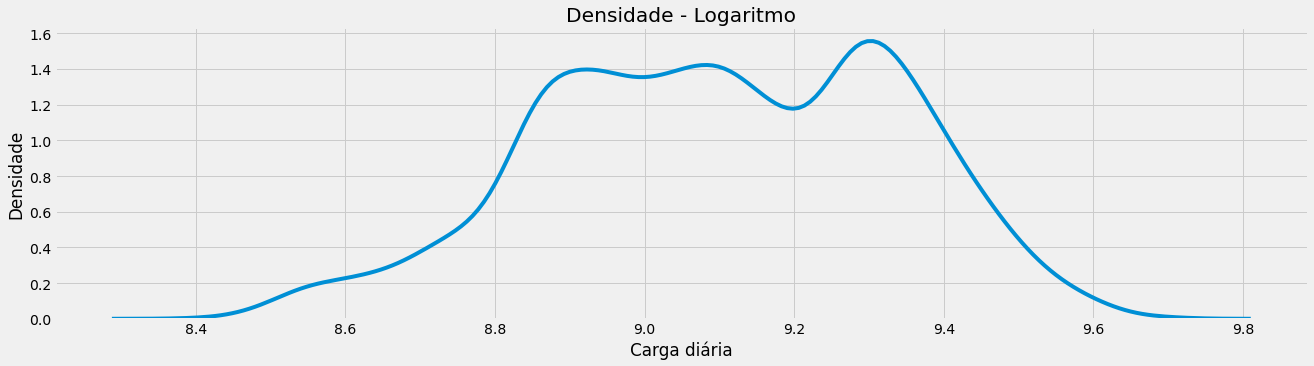

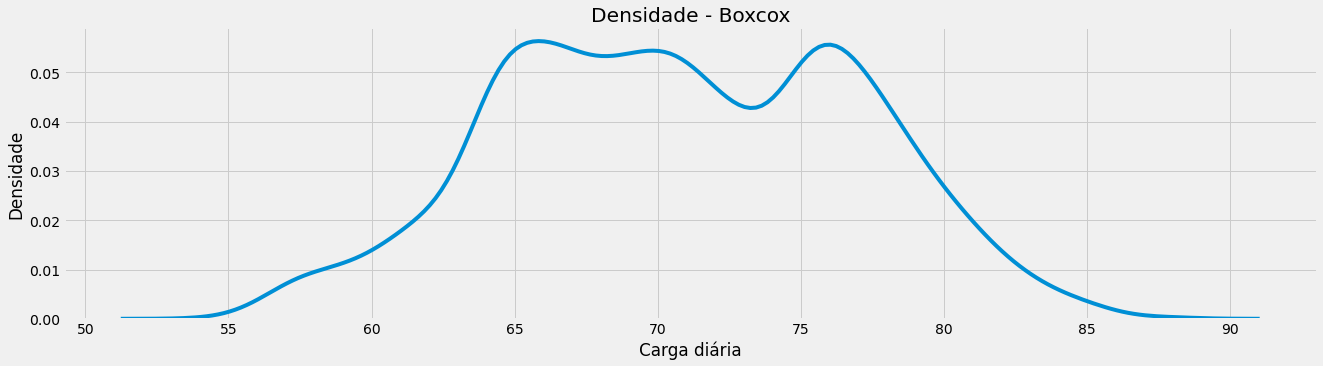

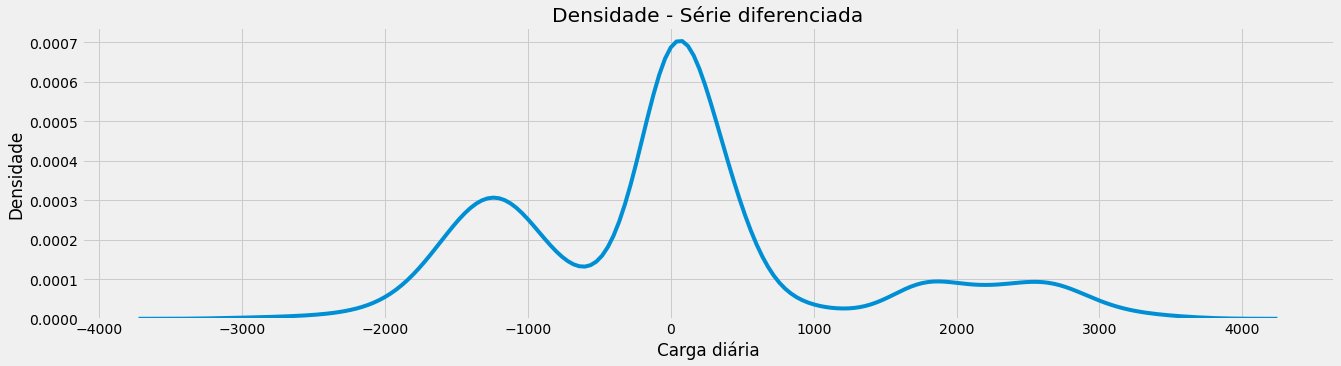

In [141]:
for nome, serie in series.items():
    plt.figure(figsize = (20, 5))
    sns.kdeplot(serie)
    plt.title(f"Densidade - {nome}")
    plt.ylabel(f"Densidade")
    plt.xlabel("Carga diária")
    plt.show()